In [165]:
import numpy as np
import gurobipy as gb
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.optimize import minimize


# Costs per worker level
costs = {5: 16000, 4: 12000, 3: 10000, 2: 7000}


def likelihood_of_accepting(q, b):
    """This function firstly calculates the likelihood of project acceptance based on 
    the average quality and bid. And after that it uses np to get if the project
    was actually accepted. 

    Args:
        q (float): average quality of the team assigned to the project.
        b (float): bid per worker

    Returns:
        binary: 0 if it was simulated that the project was accepted, and 0 otherwise.
    """
    result = 1/(1 + np.exp(-6.5 - 2*q + 0.0005*b))
    outcome = np.random.choice([0, 1], p=[1-result, result])
    return outcome


def max_greedy_bid(param, people_requirement, q, d):
    """This function provides the "objection function" for greedy strategy.
    Generally speaking, this is what we are maximizing. Maybe it's possible to make it more efficient.

    Args:
        param (float): something we want to maximize.
        pple_req (integer): amount of people needed for the project.
        q (float): average quality of the team.
        d (integer): length of the project.

    Returns:
        float: the maximized bid.
    """
    b = param

    # Here we start with minus, it's not a mistake. Thew thing is that scipy has minimization function(Check later code).
    # So we basically minimizing negative outcome, aka maximizing positive one. I know it's weird, but that's how it works
    # how this library works.
    result = -b*people_requirement*d * \
        (1 / (1 + np.exp(-6.5 - 2 * q + 0.0005 * b)))
    return result


# Maybe there is a better place to put those, but idk yet.

# Initial guess for the bid. necessary for scipy thing.
initial_guess = [0]

# Set bounds for optimization.
bounds = [(-np.inf, np.inf)]


class Simulation:
    """Instead of creating like shit tone of similar functions, i decided to combine the whole simulation process in one 
    class. Maybe we will need to break it for later strategies, but it worked fine for strategies 1 - 4. 
    """

    def __init__(self, bid=None, n=50, fixed_probability=False, greedy=False):
        """Initiate the class.

        Args:
            bid (float, optional): If bid is fixed, than we just specify it here, or None otherwise. Defaults to None.
            n (integer, optional): Number of weeks for simulation. Defaults to 50.
            fixed_probability (bool, optional): Indicator, if it's a fixed probability approach. Defaults to False.
            greedy (bool, optional): Indicator, if it's a greedy pricing. Defaults to False.
        """
        self.n = n
        self.num_of_projects_per_month = np.random.poisson(4, size=self.n)
        self.employees_scenario_1 = create_workers()
        self.bid = bid
        self.fixed_probability = fixed_probability
        self.greedy = greedy

        # This one means that whenever you create Simulation object it already runs the simulation.
        # And you directly can get all the values and plots.
        self.intitalisation()

    def monthly_behaviour(self, number_of_projects):
        """This is a main function. It simulates the monthly decisions - costs, revenue calculations, 
        workers allocations and others. Maybe it's smart to break it into smaller functions.  

        Args:
            num_of_proj (integer): amount of projects per month. It's the only simulation which is done on the higher level than months.

        Returns:
            tuple: revenues, costs and other proportions.
        """
        # We find the sum of costs of all workers who are currently engaged in project.
        monthly_costs = 0
        for key in self.employees_scenario_1.keys():
            # We are paying only to the working people, not all of them.
            if self.employees_scenario_1[key]["when_will_be_available"] != 0:
                monthly_costs += costs[self.employees_scenario_1[key]["level"]]
                # We reduce amount of "busy" periods.
                self.employees_scenario_1[key]["when_will_be_available"] -= 1
        monthly_revenue = 0
        missed_projects = 0
        taken_projects = 0
        # Sorry for not doing man/woman_months, hahha. This variable will be used in utilization calculations.
        man_months = 0

        for project in range(number_of_projects):

            # Basically, we simulate for each project the people and time requirements.
            scope_of_project = np.random.choice([3, 6], p=[0.5, 0.5])
            workers_requirement = np.random.choice(
                [3, 4, 5, 6], p=[0.2, 0.3, 0.3, 0.2])
            potential_team = []

            for worker, values in self.employees_scenario_1.items():
                # We checked for each worker their availability.
                # I just assume for now that better workers are checked first
                if len(potential_team) < workers_requirement:
                    if values["when_will_be_available"] == 0:
                        potential_team.append(worker)
            # Check if we managed to form a team
            if len(potential_team) == workers_requirement:

                # Find the average quality of the team. Works surprisingly fast.
                potential_quality = np.mean(
                    [self.employees_scenario_1[worker]["level"] for worker in potential_team])

                # It allows to hold situations, when the bid needs to be optimized.
                if not self.bid:
                    if not self.greedy:
                        # Strategy 3
                        self.bid = 2000 * (2 * potential_quality + 6.5)
                    else:
                        # It's optimization for Strategy 4
                        max_bid = minimize(max_greedy_bid, initial_guess, bounds=bounds, args=(
                            workers_requirement, potential_quality, scope_of_project,), method='L-BFGS-B')
                        self.bid = max_bid.x[0]

                # After we got to know the bid, we find out the likelihood of acceptance and if it was actually accepted.
                is_accepted = likelihood_of_accepting(
                    q=potential_quality, b=self.bid)
                if is_accepted:
                    # If our project is actually accepted
                    # I also assume that they start working on project from the next month.
                    # That's why the calc of costs is done on the beginning of the each month.
                    for person in potential_team:
                        # Add their working months.
                        self.employees_scenario_1[person]["when_will_be_available"] = scope_of_project
                        man_months += scope_of_project
                    # Yeah, this one is another assumption I make, which can be changed in the future, So right now
                    # it is assumed that in month 0 we get assigned to the project and get the whole revenue for it,
                    # while starting to paying to our workers monthly from month 1 until the end.
                    monthly_revenue += self.bid * workers_requirement * scope_of_project
                    taken_projects += 1
                else:
                    # We formed the team, but project wasn't accepted.
                    potential_team = []

            elif len(potential_team) < workers_requirement:
                # if we didn't manage to form a team.
                potential_team = []
                # I add missed projects only in this case, because in the assignment he says - "he proportion of unaddressed
                # projects due to resource limitations." So we basically find, how many projects we lost only because we don't have enough people.
                missed_projects += 1
            else:
                # If we formed a team with more people in a team than needed - error.
                print("More people in a team than needed")
                break

            # If the bid is not fixed, we need to renew it for every project.
            if self.fixed_probability or self.greedy:
                self.bid = None

        return monthly_costs, monthly_revenue, missed_projects, taken_projects, man_months

    def intitalisation(self):
        """This is orchestration function. It runs the for loop with monthly simulations and creates all the 
        necessary metrics and values for the post simulation analysis.
        """
        # Costs and revenue are saved in lists, and not as an integer, because we will need them further for plots.
        self.total_costs, self.total_revenue, self.total_missed_projects, self.total_taken_projects, self.total_man_months = [], [], 0, 0, 0

        # This is monthly simulation creation.
        for monthly_proj in self.num_of_projects_per_month:
            monthly_costs, monthly_revenue, missed_projects, taken_projects, man_months = self.monthly_behaviour(
                monthly_proj)
            self.total_costs.append(monthly_costs)
            self.total_revenue.append(monthly_revenue)
            self.total_missed_projects += missed_projects
            self.total_taken_projects += taken_projects
            self.total_man_months += man_months

        # Create the total profit list.
        self.total_profit = [self.total_revenue[i] - self.total_costs[i]
                             for i in range(len(self.total_revenue))]

        # Missed proj/all the projects. I calulate the total like this,
        # because the proportion missed_proj/taken_proj is more than 1.
        self.proportion_of_missed_proj = self.total_missed_projects / \
            (self.num_of_projects_per_month.sum())

        # Utilization of man-months out of available 40 people * 50 months.
        self.utilization_man_months = self.total_man_months/(40 * 50)

    def revenue_plot(self):
        """Creates revenue histogram.
        """
        ax = sn.histplot(self.total_revenue, kde=True, bins=50)
        ax.set(xlabel="Revenue", ylabel="Probability")
        plt.show()
        # Never forget to close the plot.
        # Otherwise each plt.show() will produce the same plot.
        plt.close()

    def profit_plot(self):
        """Creates profit histogram.
        """
        a2 = sn.histplot(self.total_profit, kde=True, bins=50)
        a2.set(xlabel="Profit", ylabel="Probability")
        plt.show()
        plt.close()

In [166]:
def create_workers():
    main_dict = {}

    # Define the number of keys for each level
    num_keys_level_2 = 8
    num_keys_level_4 = 12
    num_keys_level_3 = 15
    num_keys_level_2 = 5

    # Populate the main dictionary with keys and corresponding dictionaries
    main_dict.update(
        {f"worker_{i}": {"level": 5, "when_will_be_available": 0} for i in range(1, num_keys_level_2 + 1)})
    main_dict.update({f"worker_{i}": {"level": 4, "when_will_be_available": 0} for i in range(
        num_keys_level_2 + 1, num_keys_level_2 + num_keys_level_4 + 1)})
    main_dict.update({f"worker_{i}": {"level": 3, "when_will_be_available": 0} for i in range(
        num_keys_level_2 + num_keys_level_4 + 1, num_keys_level_2 + num_keys_level_4 + num_keys_level_3 + 1)})
    main_dict.update({f"worker_{i}": {"level": 2, "when_will_be_available": 0} for i in range(num_keys_level_2 + num_keys_level_4 +
                     num_keys_level_3 + 1, num_keys_level_2 + num_keys_level_4 + num_keys_level_3 + num_keys_level_2 + 1)})

    # Print the resulting dictionary
    return main_dict

#### Question 6 – Employee Training
Explore the impact of enhancing employee capabilities through training. Determine the investment value for training employees from quality levels 2 and 3 to level 4, assuming no increase in their monthly compensation.


The same as for question 1 but only having level 4 and 5 then

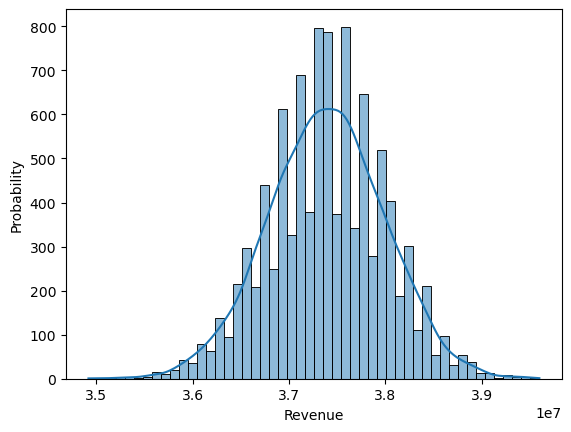

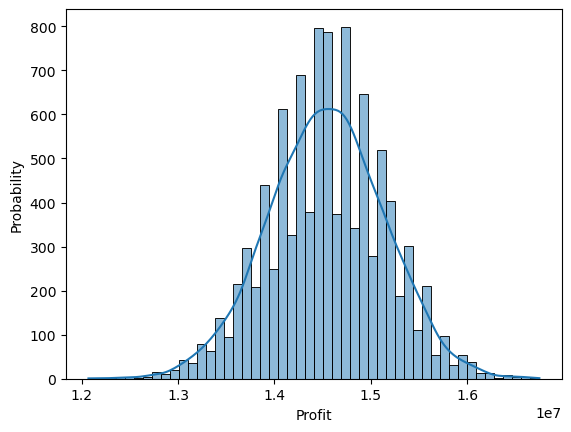

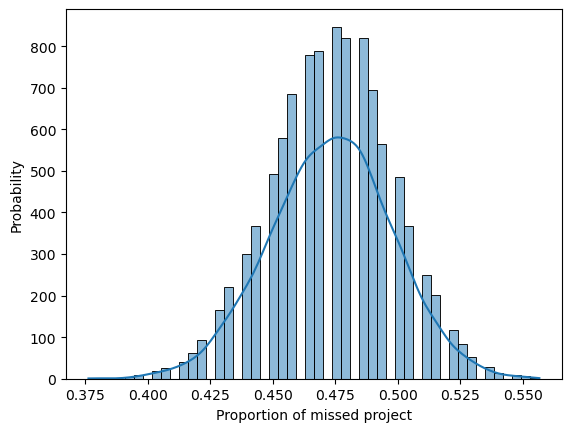

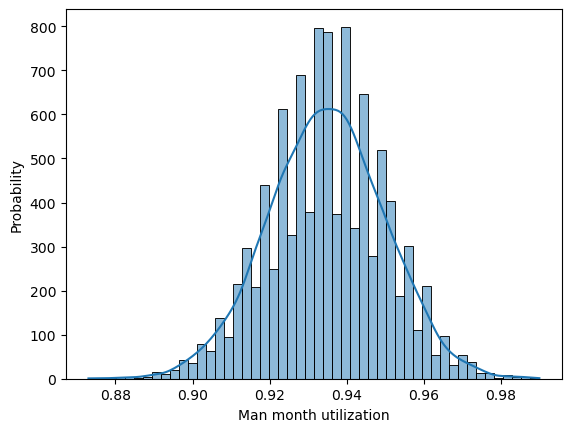

Strategy 1 Results:
Total Revenue: 37390060.99390061
Total Profit: 14540060.99390061
Proportion of Missed Projects: 0.4733485414345164
Total Man-Month Utilization: 0.9347515248475153
Total Projects Taken: 953622


0

In [161]:
import os
import numpy as np
import gurobipy as gb
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.optimize import minimize


np.random.seed(1810)

# Costs per worker level
costs = {5: 16000, 4: 12000, 3: 10000, 2: 7000}
monthly_costs = 16000 * 8 + 12000 * 12 + 10000 * 15 + 7000 * 5

def create_workers():
    main_dict = {}

    # Define the number of keys for each level
    num_keys_level_5 = 8
    num_keys_level_4 = 12
    num_keys_level_3 = 15
    num_keys_level_2 = 5

    # Populate the main dictionary with keys and corresponding dictionaries
    main_dict.update(
        {f"worker_{i}": {"level": 5, "when_will_be_available": 0} for i in range(1, num_keys_level_5 + 1)})
    main_dict.update({f"worker_{i}": {"level": 4, "when_will_be_available": 0} for i in range(
        num_keys_level_5+1, num_keys_level_5 + num_keys_level_4 + 1)})
    main_dict.update({f"worker_{i}": {"level": 3, "when_will_be_available": 0} for i in range(
        num_keys_level_5 + num_keys_level_4 + 1, num_keys_level_5 + num_keys_level_4 + num_keys_level_3 + 1)})
    main_dict.update({f"worker_{i}": {"level": 2, "when_will_be_available": 0} for i in range(num_keys_level_5 + num_keys_level_4 +
                     num_keys_level_3 + 1, num_keys_level_5 + num_keys_level_4 + num_keys_level_3 + num_keys_level_2 + 1)})

    # Print the resulting dictionary
    return main_dict


def likelihood_of_accepting(q, b):
    """This function firstly calculates the likelihood of project acceptance based on 
    the average quality and bid. And after that it uses np to get if the project
    was actually accepted. 

    Args:
        q (float): average quality of the team assigned to the project.
        b (float): bid per worker

    Returns:
        binary: 0 if it was simulated that the project was accepted, and 0 otherwise.
    """
    result = 1/(1 + np.exp(-6.5 - 2*q + 0.0005*b))
    outcome = np.random.choice([0, 1], p=[1-result, result])
    return outcome


def max_greedy_bid(param, people_requirement, q, d):
    """This function provides the "objection function" for greedy strategy.
    Generally speaking, this is what we are maximizing. Maybe it's possible to make it more efficient.

    Args:
        param (float): something we want to maximize.
        pple_req (integer): amount of people needed for the project.
        q (float): average quality of the team.
        d (integer): length of the project.

    Returns:
        float: the maximized bid.
    """
    b = param

    # Here we start with minus, it's not a mistake. Thew thing is that scipy has minimization function(Check later code).
    # So we basically minimizing negative outcome, aka maximizing positive one. I know it's weird, but that's how it works
    # how this library works.
    result = -b*people_requirement*d * \
        (1 / (1 + np.exp(-6.5 - 2 * q + 0.0005 * b)))
    return result


# Maybe there is a better place to put those, but idk yet.

# Initial guess for the bid. necessary for scipy thing.
initial_guess = [0]

# Set bounds for optimization.
bounds = [(-np.inf, np.inf)]


class Simulation:
    """Instead of creating like shit tone of similar functions, i decided to combine the whole simulation process in one 
    class. Maybe we will need to break it for later strategies, but it worked fine for strategies 1 - 4. 
    """

    def __init__(self, initialization=10000, bid=None, n=50, fixed_probability=False, greedy=False):
        """Initiate the class.

        Args:
            bid (float, optional): If bid is fixed, than we just specify it here, or None otherwise. Defaults to None.
            n (integer, optional): Number of weeks for simulation. Defaults to 50.
            fixed_probability (bool, optional): Indicator, if it's a fixed probability approach. Defaults to False.
            greedy (bool, optional): Indicator, if it's a greedy pricing. Defaults to False.
        """
        self.initialization = initialization
        self.n = n
        self.num_of_projects_per_month = np.random.poisson(4, size=self.n)
        self.employees_scenario_1 = create_workers()
        self.bid = bid
        self.fixed_probability = fixed_probability
        self.greedy = greedy

        # This one means that whenever you create Simulation object it already runs the simulation.
        # And you directly can get all the values and plots.
        self.total_initialization()

    def monthly_behaviour(self, number_of_projects):
        """This is a main function. It simulates the monthly decisions - costs, revenue calculations, 
        workers allocations and others. Maybe it's smart to break it into smaller functions.  

        Args:
            num_of_proj (integer): amount of projects per month. It's the only simulation which is done on the higher level than months.

        Returns:
            tuple: revenues, costs and other proportions.
        """
        # We find the sum of costs of all workers who are currently engaged in project.
        for key in self.employees_scenario_1.keys():
            # We are paying only to the working people, not all of them.
            if self.employees_scenario_1[key]["when_will_be_available"] != 0:
                # We reduce amount of "busy" periods.
                self.employees_scenario_1[key]["when_will_be_available"] -= 1
        monthly_revenue = 0
        missed_projects = 0
        taken_projects = 0
        # Sorry for not doing man/woman_months, hahha. This variable will be used in utilization calculations.
        man_months = 0

        for project in range(number_of_projects):

            # Basically, we simulate for each project the people and time requirements.
            scope_of_project = np.random.choice([3, 6], p=[0.5, 0.5])
            workers_requirement = np.random.choice(
                [3, 4, 5, 6], p=[0.2, 0.3, 0.3, 0.2])
            potential_team = []

            for worker, values in self.employees_scenario_1.items():
                # We checked for each worker their availability.
                # I just assume for now that better workers are checked first
                if len(potential_team) < workers_requirement:
                    if values["when_will_be_available"] == 0:
                        potential_team.append(worker)
            # Check if we managed to form a team
            if len(potential_team) == workers_requirement:

                # Find the average quality of the team. Works surprisingly fast.
                potential_quality = np.mean(
                    [self.employees_scenario_1[worker]["level"] for worker in potential_team])

                # It allows to hold situations, when the bid needs to be optimized.
                if not self.bid:
                    if not self.greedy:
                        # Strategy 3
                        self.bid = 2000 * (2 * potential_quality + 6.5)
                    else:
                        # It's optimization for Strategy 4
                        max_bid = minimize(max_greedy_bid, initial_guess, bounds=bounds, args=(
                            workers_requirement, potential_quality, scope_of_project,), method='L-BFGS-B')
                        self.bid = max_bid.x[0]

                # After we got to know the bid, we find out the likelihood of acceptance and if it was actually accepted.
                is_accepted = likelihood_of_accepting(
                    q=potential_quality, b=self.bid)
                if is_accepted:
                    # If our project is actually accepted
                    # I also assume that they start working on project from the next month.
                    # That's why the calc of costs is done on the beginning of the each month.
                    for person in potential_team:
                        # Add their working months.
                        self.employees_scenario_1[person]["when_will_be_available"] = scope_of_project
                        man_months += scope_of_project
                    # Yeah, this one is another assumption I make, which can be changed in the future, So right now
                    # it is assumed that in month 0 we get assigned to the project and get the whole revenue for it,
                    # while starting to paying to our workers monthly from month 1 until the end.
                    monthly_revenue += self.bid * workers_requirement * scope_of_project
                    taken_projects += 1
                else:
                    # We formed the team, but project wasn't accepted.
                    potential_team = []

            elif len(potential_team) < workers_requirement:
                # If we didn't manage to form a team.
                potential_team = []
                # I add missed projects only in this case, because in the assignment he says - "he proportion of unaddressed
                # projects due to resource limitations." So we basically find, how many projects we lost only because we don't have enough people.
                missed_projects += 1
            else:
                # If we formed a team with more people in a team than needed - error.
                print("More people in a team than needed")
                break

            # If the bid is not fixed, we need to renew it for every project.
            if self.fixed_probability or self.greedy:
                self.bid = None

        return monthly_revenue, missed_projects, taken_projects, man_months

    def _one_go_intitalisation(self):
        """This is orchestration function. It runs the for loop with monthly simulations and creates all the 
        necessary metrics and values for the post simulation analysis.
        """
        # Costs and revenue are saved in lists, and not as an integer, because we will need them further for plots.
        one_go_total_revenue, one_go_total_missed_projects, one_go_total_taken_projects, one_go_total_man_months = 0, 0, 0, 0

        # This is monthly simulation creation.
        for monthly_proj in self.num_of_projects_per_month:
            monthly_revenue, missed_projects, taken_projects, man_months = self.monthly_behaviour(
                monthly_proj)
            one_go_total_revenue += monthly_revenue
            one_go_total_missed_projects += missed_projects
            one_go_total_taken_projects += taken_projects
            one_go_total_man_months += man_months

        one_go_total_costs = monthly_costs * self.n

        # Create the total profit list.
        one_go_total_profit = one_go_total_revenue - one_go_total_costs

        # Missed proj/all the projects. I calulate the total like this,
        # because the proportion missed_proj/taken_proj is more than 1.
        one_go_proportion_of_missed_proj = one_go_total_missed_projects / \
            (self.num_of_projects_per_month.sum())

        # Utilization of man-months out of available 40 people * 50 months.
        one_go_utilization_man_months = one_go_total_man_months/(40 * 50)

        return one_go_total_revenue, one_go_total_profit, one_go_proportion_of_missed_proj, one_go_utilization_man_months, one_go_total_taken_projects

    def total_initialization(self):

        self.total_revenue, self.total_profit, self.proportion_of_missed_proj, self.total_utilization, self.total_projects = [], [], [], [], []

        for initialization in range(self.initialization + 1):

            one_go_total_revenue, one_go_total_profit, one_go_proportion_of_missed_proj, one_go_utilization_man_months, one_go_total_taken_projects = self._one_go_intitalisation()
            self.total_revenue.append(one_go_total_revenue)
            self.total_profit.append(one_go_total_profit)
            self.proportion_of_missed_proj.append(
                one_go_proportion_of_missed_proj)
            self.total_utilization.append(one_go_utilization_man_months)
            self.total_projects.append(one_go_total_taken_projects)

    def revenue_plot(self):
        """Creates revenue histogram.
        """
        ax = sn.histplot(self.total_revenue, kde=True, bins=50)
        ax.set(xlabel="Revenue", ylabel="Probability")
        plt.show()
        # Never forget to close the plot.
        # Otherwise each plt.show() will produce the same plot.
        plt.close()

    def profit_plot(self):
        """Creates profit histogram.
        """
        a2 = sn.histplot(self.total_profit, kde=True, bins=50)
        a2.set(xlabel="Profit", ylabel="Probability")
        plt.show()
        plt.close()

    def missed_project_proportion_plot(self):
        """Creates profit histogram.
        """
        a2 = sn.histplot(self.proportion_of_missed_proj, kde=True, bins=50)
        a2.set(xlabel="Proportion of missed project", ylabel="Probability")
        plt.show()
        plt.close()

    def man_month_utilization_plot(self):
        """Creates profit histogram.
        """
        a2 = sn.histplot(self.total_utilization, kde=True, bins=50)
        a2.set(xlabel="Man month utilization", ylabel="Probability")
        plt.show()
        plt.close()



# Strategy 1:
strategy_1 = Simulation(bid=20000)
strategy_1.total_initialization()
strategy_1.revenue_plot()
strategy_1.profit_plot()
strategy_1.missed_project_proportion_plot()
strategy_1.man_month_utilization_plot()
total_revenue_strategy_1 = np.mean(strategy_1.total_revenue)
total_profit_strategy_1 = np.mean(strategy_1.total_profit)
proportion_of_missed_proj_strategy_1 = np.mean(strategy_1.proportion_of_missed_proj)
total_utilization_strategy_1 = np.mean(strategy_1.total_utilization)
total_projects_1 = np.sum(strategy_1.total_projects)

# Comparison
print("Strategy 1 Results:")
print("Total Revenue:", total_revenue_strategy_1)
print("Total Profit:", total_profit_strategy_1)
print("Proportion of Missed Projects:", proportion_of_missed_proj_strategy_1)
print("Total Man-Month Utilization:", total_utilization_strategy_1)
print("Total Projects Taken:", total_projects_1)

os.system('say "period"')

In [163]:
np.random.seed(1810)

def create_workers():
    main_dict = {}

    # Define the number of keys for each level
    num_keys_level_5 = 8
    num_keys_level_4 = 12
    num_keys_level_3 = 15
    num_keys_level_2 = 5

    # Populate the main dictionary with keys and corresponding dictionaries
    main_dict.update(
        {f"worker_{i}": {"level": 5, "when_will_be_available": 0} for i in range(1, num_keys_level_5 + 1)})
    main_dict.update({f"worker_{i}": {"level": 4, "when_will_be_available": 0} for i in range(
        num_keys_level_5+1, num_keys_level_5 + num_keys_level_4 + 1)})
    main_dict.update({f"worker_{i}": {"level": 3, "when_will_be_available": 0} for i in range(
        num_keys_level_5 + num_keys_level_4 + 1, num_keys_level_5 + num_keys_level_4 + num_keys_level_3 + 1)})
    main_dict.update({f"worker_{i}": {"level": 2, "when_will_be_available": 0} for i in range(num_keys_level_5 + num_keys_level_4 +
                     num_keys_level_3 + 1, num_keys_level_5 + num_keys_level_4 + num_keys_level_3 + num_keys_level_2 + 1)})

    # Print the resulting dictionary
    return main_dict


create_workers()

class Strategy6Simulation(Simulation):
    def __init__(self, initialization=10000, bid=None, n=50, fixed_probability=False, greedy=False):
        """Initiate the class.

        Args:
            bid (float, optional): If bid is fixed, than we just specify it here, or None otherwise. Defaults to None.
            n (integer, optional): Number of weeks for simulation. Defaults to 50.
            fixed_probability (bool, optional): Indicator, if it's a fixed probability approach. Defaults to False.
            greedy (bool, optional): Indicator, if it's a greedy pricing. Defaults to False.
        """
        self.initialization = initialization
        self.n = n
        self.num_of_projects_per_month = np.random.poisson(4, size=self.n)
        self.employees_scenario_6 = create_workers()
        self.bid = bid
        self.fixed_probability = fixed_probability
        self.greedy = greedy

        # This one means that whenever you create Simulation object it already runs the simulation.
        # And you directly can get all the values and plots.
        self.total_initialization()

    def train_employees(self):
        for key, values in self.employees_scenario_6.items():
            if values["level"] == 2 or values["level"] == 3:
            # Update the level to 4
                values["level"] = 4
            # Keep the monthly compensation the same as their original level
                values["monthly_compensation"] = costs[values["level"]]
                
    def monthly_behaviour(self, number_of_projects):
        """This is a main function. It simulates the monthly decisions - costs, revenue calculations, 
        workers allocations and others. Maybe it's smart to break it into smaller functions.  

        Args:
            num_of_proj (integer): amount of projects per month. It's the only simulation which is done on the higher level than months.

        Returns:
            tuple: revenues, costs and other proportions.
        """
        # We find the sum of costs of all workers who are currently engaged in project.
        self.train_employees()
        for key in self.employees_scenario_6.keys():
            # We are paying only to the working people, not all of them.
            if self.employees_scenario_6[key]["when_will_be_available"] != 0:
                # We reduce amount of "busy" periods.
                self.employees_scenario_6[key]["when_will_be_available"] -= 1
        monthly_revenue = 0
        missed_projects = 0
        taken_projects = 0
        # Sorry for not doing man/woman_months, hahha. This variable will be used in utilization calculations.
        man_months = 0

        for project in range(number_of_projects):

            # Basically, we simulate for each project the people and time requirements.
            scope_of_project = np.random.choice([3, 6], p=[0.5, 0.5])
            workers_requirement = np.random.choice(
                [3, 4, 5, 6], p=[0.2, 0.3, 0.3, 0.2])
            potential_team = []

            for worker, values in self.employees_scenario_6.items():
                # We checked for each worker their availability.
                # I just assume for now that better workers are checked first
                if len(potential_team) < workers_requirement:
                    if values["when_will_be_available"] == 0:
                        potential_team.append(worker)
            # Check if we managed to form a team
            if len(potential_team) == workers_requirement:

                # Find the average quality of the team. Works surprisingly fast.
                potential_quality = np.mean(
                    [self.employees_scenario_6[worker]["level"] for worker in potential_team])

                # It allows to hold situations, when the bid needs to be optimized.
                if not self.bid:
                    if not self.greedy:
                        # Strategy 3
                        self.bid = 2000 * (2 * potential_quality + 6.5)
                    else:
                        # It's optimization for Strategy 4
                        max_bid = minimize(max_greedy_bid, initial_guess, bounds=bounds, args=(
                            workers_requirement, potential_quality, scope_of_project,), method='L-BFGS-B')
                        self.bid = max_bid.x[0]

                # After we got to know the bid, we find out the likelihood of acceptance and if it was actually accepted.
                is_accepted = likelihood_of_accepting(
                    q=potential_quality, b=self.bid)
                if is_accepted:
                    # If our project is actually accepted
                    # I also assume that they start working on project from the next month.
                    # That's why the calc of costs is done on the beginning of the each month.
                    for person in potential_team:
                        # Add their working months.
                        self.employees_scenario_6[person]["when_will_be_available"] = scope_of_project
                        man_months += scope_of_project
                    # Yeah, this one is another assumption I make, which can be changed in the future, So right now
                    # it is assumed that in month 0 we get assigned to the project and get the whole revenue for it,
                    # while starting to paying to our workers monthly from month 1 until the end.
                    monthly_revenue += self.bid * workers_requirement * scope_of_project
                    taken_projects += 1
                else:
                    # We formed the team, but project wasn't accepted.
                    potential_team = []

            elif len(potential_team) < workers_requirement:
                # If we didn't manage to form a team.
                potential_team = []
                # I add missed projects only in this case, because in the assignment he says - "he proportion of unaddressed
                # projects due to resource limitations." So we basically find, how many projects we lost only because we don't have enough people.
                missed_projects += 1
            else:
                # If we formed a team with more people in a team than needed - error.
                print("More people in a team than needed")
                break

            # If the bid is not fixed, we need to renew it for every project.
            if self.fixed_probability or self.greedy:
                self.bid = None

        return monthly_revenue, missed_projects, taken_projects, man_months

    def _one_go_intitalisation(self):
        """This is orchestration function. It runs the for loop with monthly simulations and creates all the 
        necessary metrics and values for the post simulation analysis.
        """
        # Costs and revenue are saved in lists, and not as an integer, because we will need them further for plots.
        one_go_total_revenue, one_go_total_missed_projects, one_go_total_taken_projects, one_go_total_man_months = 0, 0, 0, 0

        # This is monthly simulation creation.
        for monthly_proj in self.num_of_projects_per_month:
            monthly_revenue, missed_projects, taken_projects, man_months = self.monthly_behaviour(
                monthly_proj)
            one_go_total_revenue += monthly_revenue
            one_go_total_missed_projects += missed_projects
            one_go_total_taken_projects += taken_projects
            one_go_total_man_months += man_months

        one_go_total_costs = monthly_costs * self.n

        # Create the total profit list.
        one_go_total_profit = one_go_total_revenue - one_go_total_costs

        # Missed proj/all the projects. I calulate the total like this,
        # because the proportion missed_proj/taken_proj is more than 1.
        one_go_proportion_of_missed_proj = one_go_total_missed_projects / \
            (self.num_of_projects_per_month.sum())

        # Utilization of man-months out of available 40 people * 50 months.
        one_go_utilization_man_months = one_go_total_man_months/(40 * 50)

        return one_go_total_revenue, one_go_total_profit, one_go_proportion_of_missed_proj, one_go_utilization_man_months, one_go_total_taken_projects

    def total_initialization(self):

        self.total_revenue, self.total_profit, self.proportion_of_missed_proj, self.total_utilization, self.total_projects = [], [], [], [], []

        for initialization in range(self.initialization + 1):

            one_go_total_revenue, one_go_total_profit, one_go_proportion_of_missed_proj, one_go_utilization_man_months, one_go_total_taken_projects = self._one_go_intitalisation()
            self.total_revenue.append(one_go_total_revenue)
            self.total_profit.append(one_go_total_profit)
            self.proportion_of_missed_proj.append(
                one_go_proportion_of_missed_proj)
            self.total_utilization.append(one_go_utilization_man_months)
            self.total_projects.append(one_go_total_taken_projects)

    def revenue_plot(self):
        """Creates revenue histogram.
        """
        ax = sn.histplot(self.total_revenue, kde=True, bins=50)
        ax.set(xlabel="Revenue", ylabel="Probability")
        plt.show()
        # Never forget to close the plot.
        # Otherwise each plt.show() will produce the same plot.
        plt.close()

    def profit_plot(self):
        """Creates profit histogram.
        """
        a2 = sn.histplot(self.total_profit, kde=True, bins=50)
        a2.set(xlabel="Profit", ylabel="Probability")
        plt.show()
        plt.close()

    def missed_project_proportion_plot(self):
        """Creates profit histogram.
        """
        a2 = sn.histplot(self.proportion_of_missed_proj, kde=True, bins=50)
        a2.set(xlabel="Proportion of missed project", ylabel="Probability")
        plt.show()
        plt.close()

    def man_month_utilization_plot(self):
        """Creates profit histogram.
        """
        a2 = sn.histplot(self.total_utilization, kde=True, bins=50)
        a2.set(xlabel="Man month utilization", ylabel="Probability")
        plt.show()
        plt.close()


In [164]:
# Strategy 1:
strategy_1 = Simulation(bid=20000)
strategy_1.total_initialization()

# Strategy 6:
strategy_6 = Strategy6Simulation(bid=20000)
strategy_6.total_initialization()

# Results for Strategy 1
total_revenue_strategy_1 = np.mean(strategy_1.total_revenue)
total_profit_strategy_1 = np.mean(strategy_1.total_profit)
proportion_of_missed_proj_strategy_1 = np.mean(strategy_1.proportion_of_missed_proj)
total_utilization_strategy_1 = np.mean(strategy_1.total_utilization)
total_projects_1 = np.sum(strategy_1.total_projects)

# Results for Strategy 6
total_revenue_strategy_6 = np.mean(strategy_6.total_revenue)
total_profit_strategy_6 = np.mean(strategy_6.total_profit)
proportion_of_missed_proj_strategy_6 = np.mean(strategy_6.proportion_of_missed_proj)
total_utilization_strategy_6 = np.mean(strategy_6.total_utilization)
total_projects_6 = np.sum(strategy_6.total_projects)

# Comparison
print("Strategy 1 Results:")
print("Total Revenue:", total_revenue_strategy_1)
print("Total Profit:", total_profit_strategy_1)
print("Proportion of Missed Projects:", proportion_of_missed_proj_strategy_1)
print("Total Man-Month Utilization:", total_utilization_strategy_1)
print("Total Projects Taken:", total_projects_1)
# need to extract the total projects for strategy 1

print("\nStrategy 6 Results:")
print("Total Revenue:", total_revenue_strategy_6)
print("Total Profit:", total_profit_strategy_6)
print("Proportion of Missed Projects:", proportion_of_missed_proj_strategy_6)
print("Total Man-Month Utilization:", total_utilization_strategy_6)
print("Total Projects Taken:", total_projects_6)

os.system('say "period"')

Strategy 1 Results:
Total Revenue: 37390060.99390061
Total Profit: 14540060.99390061
Proportion of Missed Projects: 0.4733485414345164
Total Man-Month Utilization: 0.9347515248475153
Total Projects Taken: 953622

Strategy 6 Results:
Total Revenue: 38151402.85971403
Total Profit: 15301402.85971403
Proportion of Missed Projects: 0.5000073596701243
Total Man-Month Utilization: 0.9537850714928507
Total Projects Taken: 976685


0